In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import blackjack as b21
import matplotlib.pyplot as plt

from numba import njit, prange

In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True)

### Analysing play-by-play

In [4]:
# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy_init = np.zeros((
    b21.PLAY_MAXVAL - b21.PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    10, # Dealer's one showing card
    2, # hit or stick
), dtype=np.int32)

policy_init[:-2, ..., 1] = 1 # hit for v < 20
policy_init[-2:, ..., 0] = 1 # stick for v >= 20
# policy.shape

### Analysing play-by-play

In [5]:
b21.set_seed(31415)

discount = 1
state_init = b21.init_game()
reward, values, hist = b21.play_single_hist(*state_init, policy=policy_init)

hist_state, hist_action, hist_reward = hist

hist_state

[[12, 0, 6], [21, 0, 6]]

In [6]:
hist_action

[1, 0]

In [7]:
hist_reward

[0, 1]

## Estimating the value function via first-visit MC

In [8]:
@njit
def first_visit_mc_control(policy_init, n_sims):
    policy = policy_init.copy()
    grid_rewards = np.zeros_like(policy)
    grid_count = np.zeros_like(policy)
    
    for s in range(n_sims):
        hits = b21.single_first_visit_mc(policy)
        for element in hits:
            ixs, sim_reward, action = element
            ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs
            if (ix_value_cards + b21.PLAY_MINVAL) > 21:
                continue
                        
            ix_update = ix_value_cards, ix_has_usable_ace, ix_dealers_card, action
            ix_eval = ix_value_cards, ix_has_usable_ace, ix_dealers_card
                        
            grid_rewards[ix_update] += sim_reward
            grid_count[ix_update] += 1
            
            # Improvement
            expected_return = grid_rewards[ix_eval] / np.maximum(grid_count[ix_eval], 1)
            
            epsilon = 0.05
            n_actions = len(expected_return)
            new_action = expected_return.argmax()
            
            ix_improve = *ix_eval, new_action
            # policy[ix_eval] = 0 # reset actions
            # policy[ix_improve] = 1 # update the single action
            
            policy[ix_eval] = epsilon / n_actions
            policy[ix_improve] = 1 - epsilon + epsilon / n_actions
            
    
    return grid_rewards, grid_count, policy

In [9]:
range_value_cards = np.arange(b21.PLAY_MINVAL, b21.PLAY_MAXVAL + 1)
range_dealers_card = np.arange(1, 11)

In [10]:
# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy_init_shape = (
    b21.PLAY_MAXVAL - b21.PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    10, # Dealer's one showing card
    2, # hit or stick
)
policy_init = np.zeros(policy_init_shape, dtype=np.float32)

policy_init[:-1, ..., 1] = 1 # hit for v < 20
policy_init[-1:, ..., 0] = 1 # stick for v >= 20
# policy.shape

In [11]:
%%time
b21.set_seed(31415)
n_sims = 5_000_000
grid_rewards, grid_count, policy_final = first_visit_mc_control(policy_init, n_sims)

CPU times: user 7.55 s, sys: 18.6 ms, total: 7.57 s
Wall time: 7.54 s


In [12]:
policy_final_ace = pd.DataFrame(
    policy_final[:, 1, :, 1],
    index=range_value_cards,
    columns=range_dealers_card
)

policy_final_no_ace = pd.DataFrame(
    policy_final[:, 0, :, 1],
    index=range_value_cards,
    columns=range_dealers_card
)

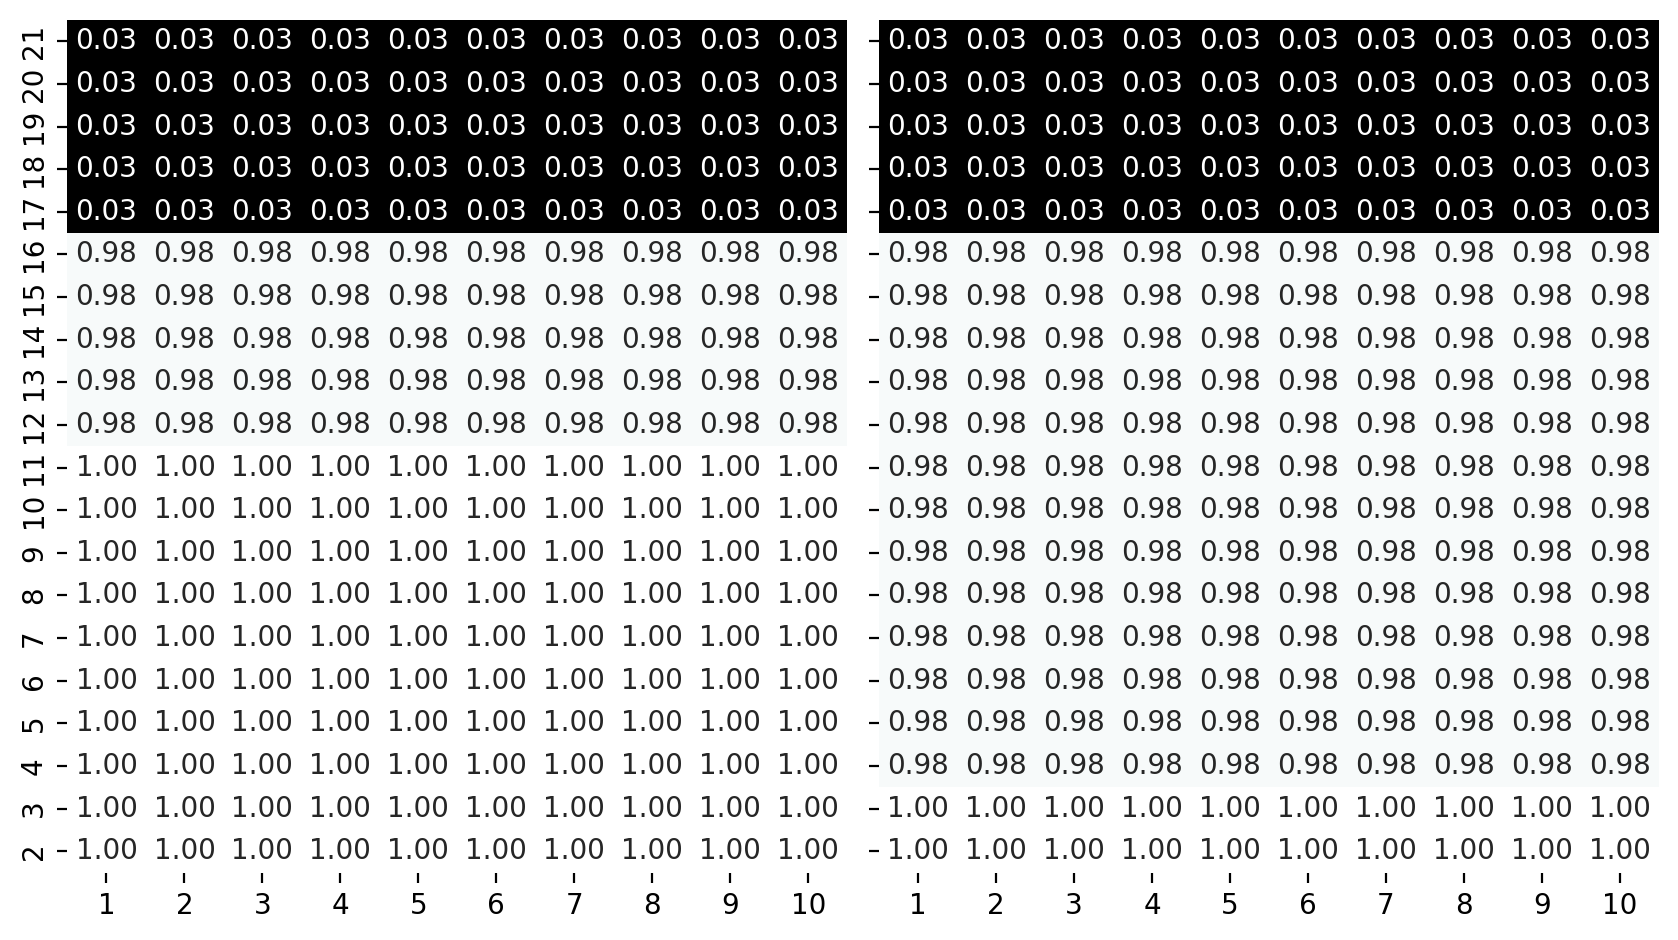

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4.8), sharey=True)

sns.heatmap(policy_final_ace, cmap="bone", annot=True, ax=ax[0], cbar=False, fmt="0.2f")
sns.heatmap(policy_final_no_ace, cmap="bone", annot=True, ax=ax[1], cbar=False, fmt="0.2f")
ax[1].invert_yaxis()

plt.tight_layout()

## Eval

In [14]:
%%time
grid_rewards, grid_count = b21.first_visit_mc_eval(policy_final, 1_000_000)

grid_value_function = grid_rewards / grid_count

vf_no_ace = grid_value_function[:, 0, :]
vf_no_ace = pd.DataFrame(vf_no_ace, index=range_value_cards, columns=range_dealers_card)

vf_ace = grid_value_function[:, 1, :]
vf_ace = pd.DataFrame(vf_ace, index=range_value_cards, columns=range_dealers_card)

CPU times: user 5.36 s, sys: 29.3 ms, total: 5.39 s
Wall time: 1.77 s


<timed exec>:3: RuntimeWarning: invalid value encountered in divide


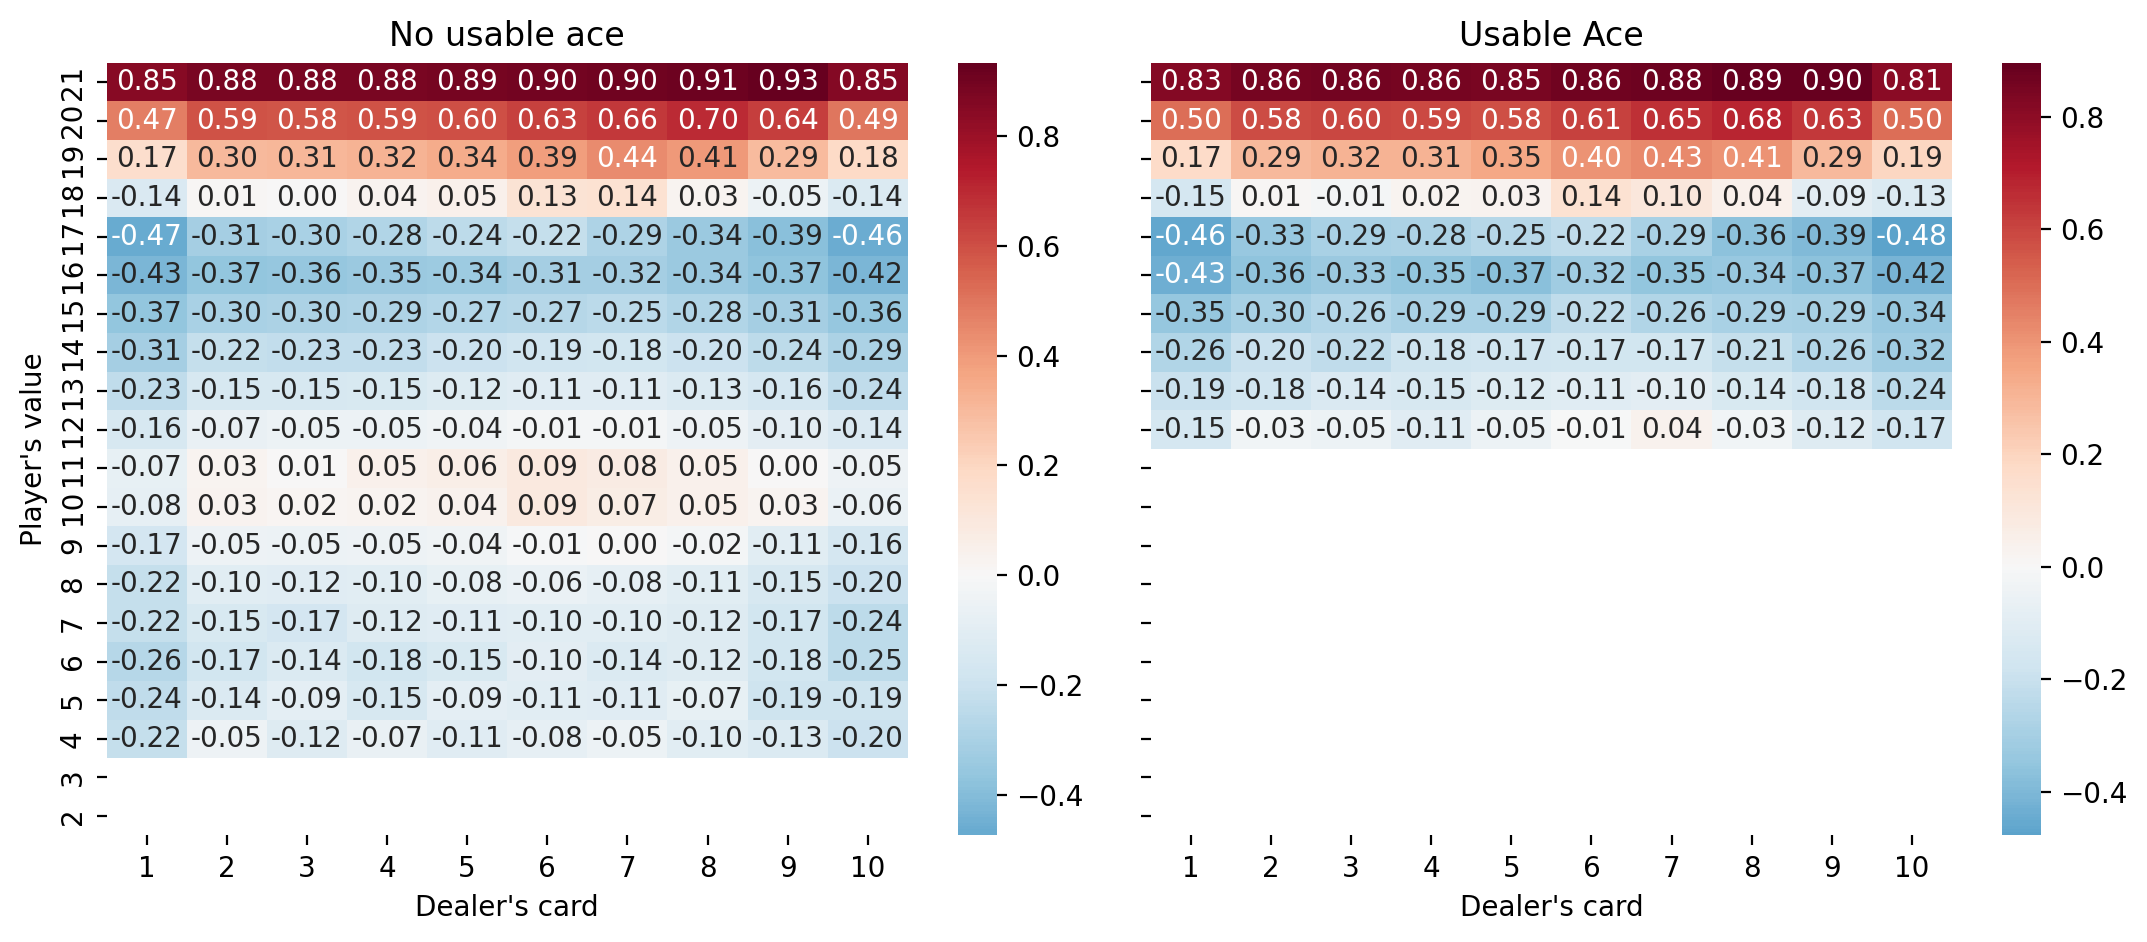

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4.8), sharey=True)
for axi, vf in zip(ax, [vf_no_ace, vf_ace]):
    sns.heatmap(vf, cmap="RdBu_r", ax=axi, annot=True, fmt="0.2f", center=0.0)
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.tight_layout()

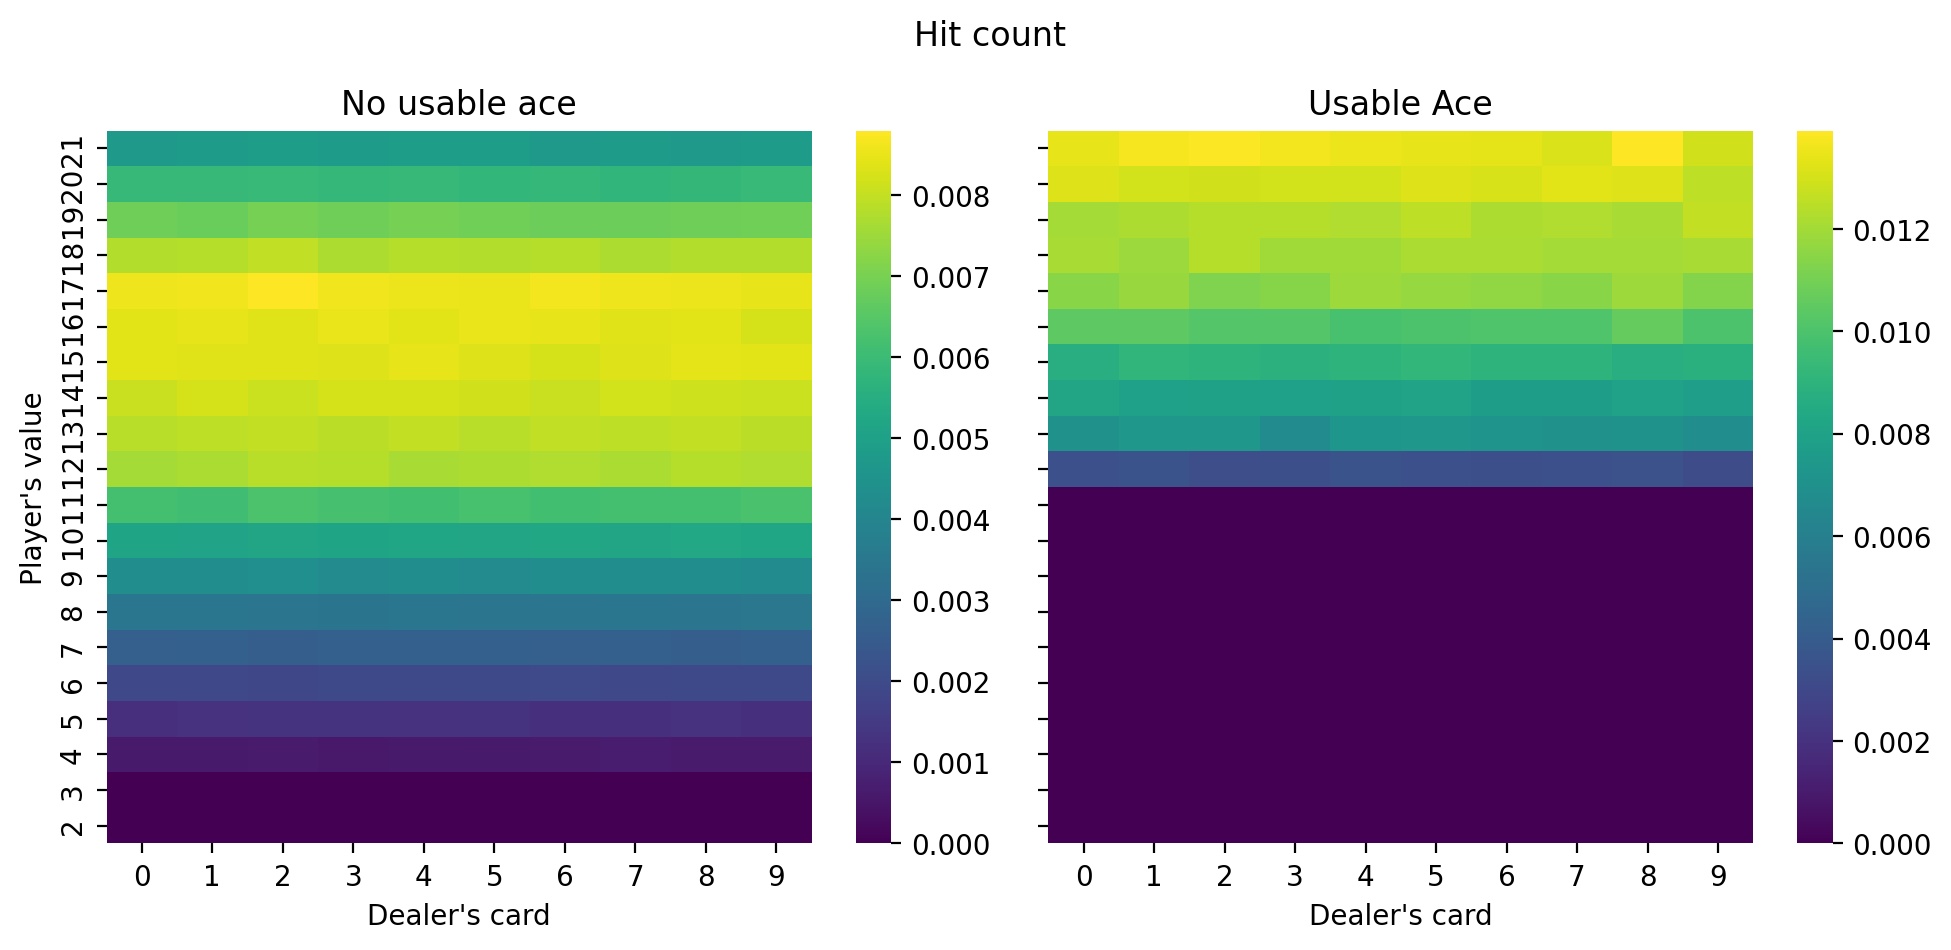

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.8), sharey=True)

for i, axi in enumerate(ax):
    p_grid = grid_count[:, i, :]
    p_grid = p_grid / p_grid.sum()
    vf = pd.DataFrame(p_grid, index=range_value_cards, )
    sns.heatmap(vf, cmap="viridis", ax=axi)
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.suptitle("Hit count")
plt.tight_layout()